# Diagnostics

If mlflow is not being used, then the data will be saved in an output directory.

## Import libraries and define some functions

In [1]:
# Import some basic libraries
import h5py, os, yaml
import numpy as np
from scipy import special
import xarray as xr

# Import JAX
from jax import config
config.update("jax_enable_x64", True)
from jax import numpy as jnp

# Ignore some of the mlflow defaults
import mlflow
mlflow.set_tracking_uri("file:///path/to/mlruns")

# Import some super-jax plotting routines
import super_jax.plotting as sjp

# Import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.facecolor"] = (1,1,1,1)

# This will make a directory called tmp on scratch (if it does not already exist) for storing file output temporarily
# This is to help speed up file output on NERSC
if "SCRATCH" in os.environ:
    tmp_dir = os.path.join(os.environ.get("SCRATCH"), "tmp")
else:
    tmp_dir = "tmp"
if not os.path.exists(tmp_dir):
    os.makedirs(tmp_dir)
os.environ['BASE_TEMPDIR'] = tmp_dir


# Define a function to get basic grid parameters from the cfg dictionary
def get_grid_vars(cfg):
    t0 = cfg["grid"]["tmin"]
    t1 = cfg["grid"]["tmax"]
    dt = (cfg["grid"]["tmax"] - cfg["grid"]["tmin"]) / (cfg["grid"]["nt"] - 1)

    # Grid wavelength
    lambda0 = cfg["grid"]["lambda0"]
    
    j_zeros = np.array(special.jn_zeros(0, cfg["grid"]["nx"][1]))
    kR = j_zeros[-1]
    rmax = cfg["grid"]["xmax"][1]
    kmax = j_zeros[-1] / rmax
    r = rmax * j_zeros / kR

    # Array of the perpendicular wavevectors
    kperp = j_zeros / rmax

    # Derivative of the r array
    dr = np.concatenate(
        (np.array([(r[1] + r[0]) / 2]), (r[2:] - r[:-2]) / 2, np.array([(r[-1] + (r[-1] - r[-3]) / 2 - r[-2]) / 2]))
    )

    # Frequency array
    omega = 2 * np.pi * np.fft.fftfreq(cfg["grid"]["nt"], d=dt)

    # The index up to which the frequencies are positive
    i_pos_omega = int(cfg["grid"]["nt"] / 2)
    
    A = np.array(np.abs(special.j1(j_zeros)))
    T = np.array(special.j0(np.outer(j_zeros / kR, j_zeros)) / np.outer(A, A) / kR)
    all_t = t1 - t0

    # This matrix, when left-matrix-multiplied to the electric field, performs a Hankel transform
    T_R2K = 4.0 * np.pi * (rmax / kmax) * A[:, np.newaxis] * T / A[np.newaxis, :] * all_t

    return lambda0, kperp, dr, omega, i_pos_omega, T_R2K

# Run the simulation

MLflow Version: 2.19.0
MLflow Tracking URI: file:///path/to/mlruns
Max signal advance/slip: 4248.811706 time cells per z step
Total signal advance/slip: 429129.98 time cells over the simulation distance
max(abs(k))*dz = 25.8118224
Keldysh parameter at zmin: 2.850740
P/Pcrit = 0.000055


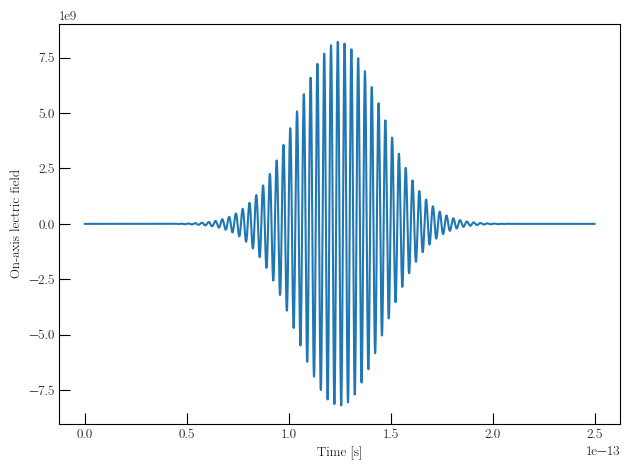

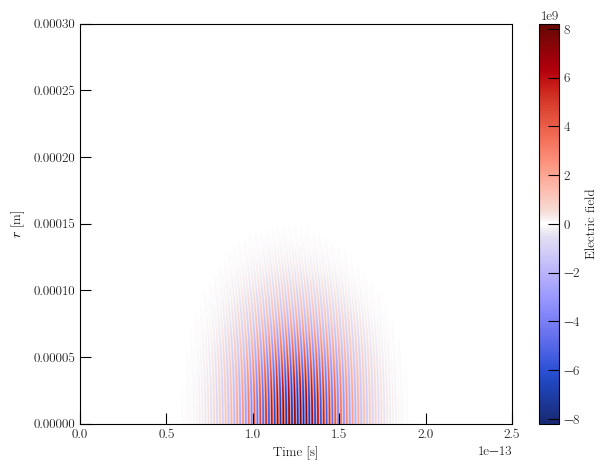

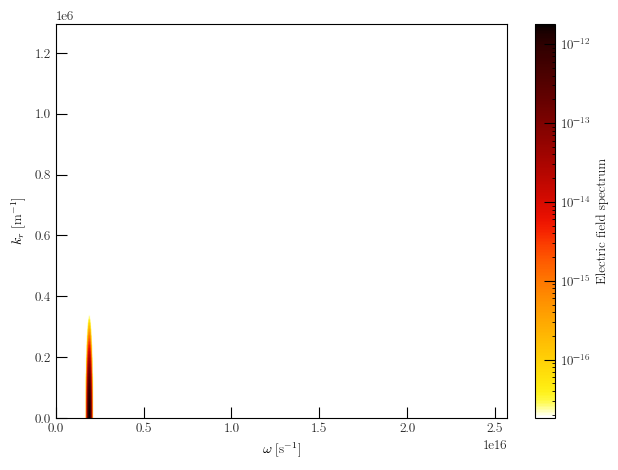

/Users/kmill/anaconda3/envs/super_jax_jupyter/lib/python3.10/site-packages/equinox/_jit.py:55: UserWarning: Complex dtype support in Diffrax is a work in progress and may not yet produce correct results. Consider splitting your computation into real and imaginary parts instead.
  out = fun(*args, **kwargs)


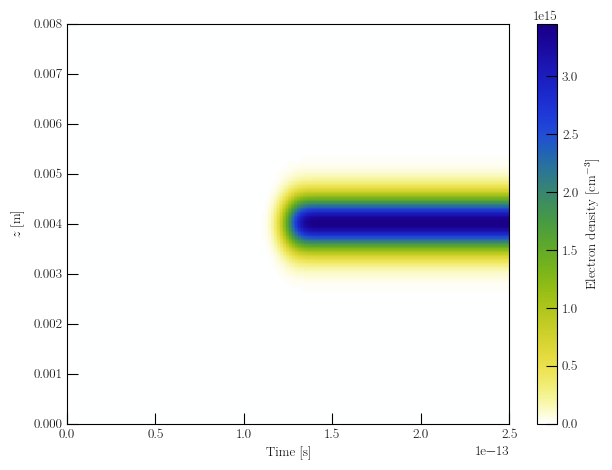

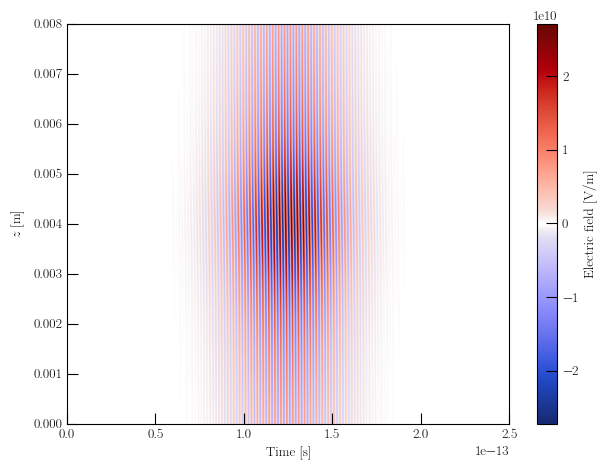

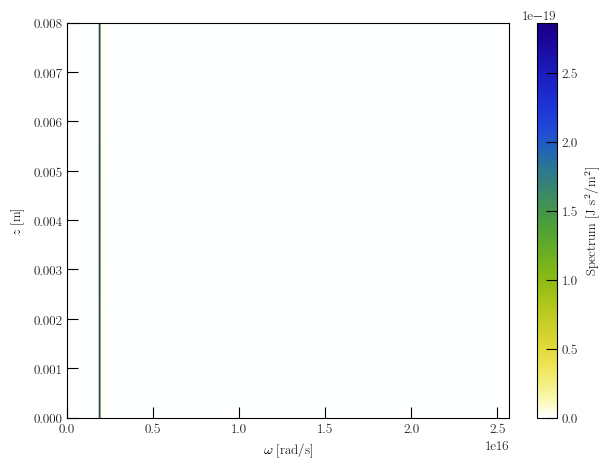

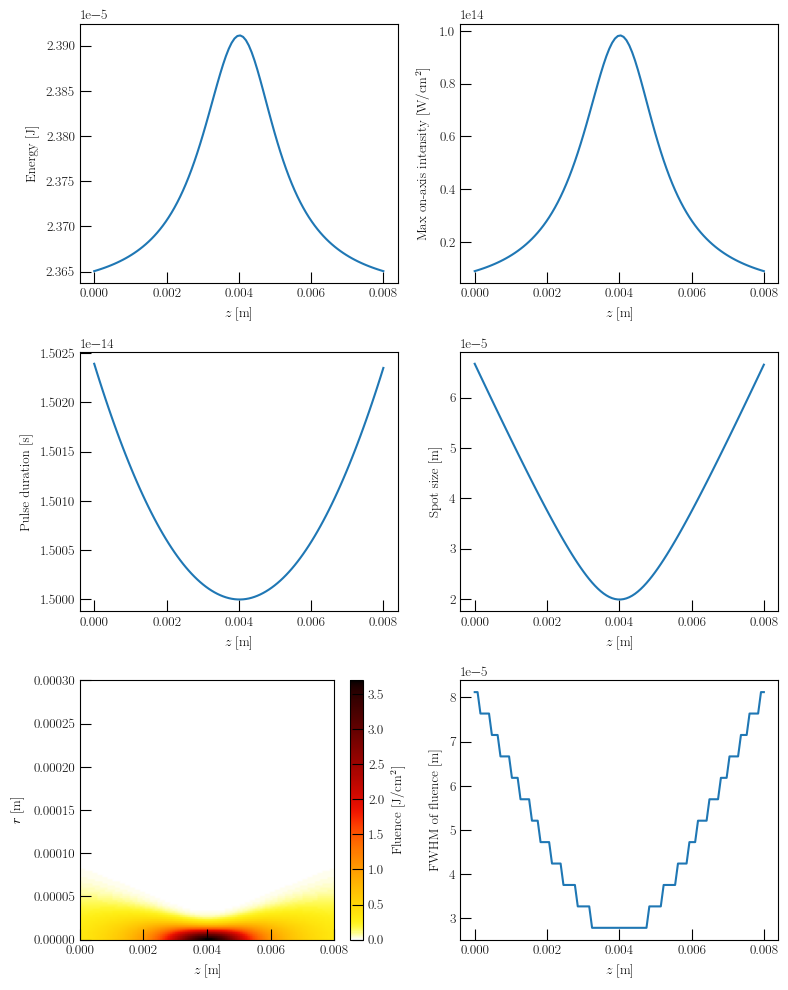

<Figure size 640x480 with 0 Axes>

In [2]:
# Run an input deck by specifying it as an argument to the command %run run.py
%run run.py "configs/default.yaml"

## Import and plot the data

In [3]:
data_dir = "output/gaussian-1/"

# Load in the input file as a dictionary
with open(os.path.join(data_dir, "config.yaml"), "r") as fi:
    cfg = yaml.safe_load(fi)

# Construct useful variables from the input deck
lambda0, kperp, dr, omega, i_pos_omega, T_R2K = get_grid_vars(cfg)

# Load in xarray data

# A dataset with multiple quantities that are accessed like a dictionary
ds_line = xr.open_dataset(os.path.join(data_dir, "data_line.h5"), engine="h5netcdf")

# Data arrays with a single quantitiy that behave more like a numpy array
da_e = xr.open_dataarray(os.path.join(data_dir, "E_full.h5"), engine="h5netcdf")
da_ne = xr.open_dataarray(os.path.join(data_dir, "ne_full.h5"), engine="h5netcdf")

# You can access the data coordinates for these xarrays if you like
z_line = ds_line.coords['z'].values
r = ds_line.coords['r'].values # or equivalently, r = da_e.coords['r'].values
t = ds_line.coords['t'].values
z_full = da_e.coords['z'].values

In [4]:
# Plotting the data is easy.  First, let's take a look at the available keys in the lineout dataset
print(list(ds_line.keys()))

['E', 'ne', 'U', 'tau', 'w0', 'I0', 'fluence', 'fwhm_fl', 'streak']


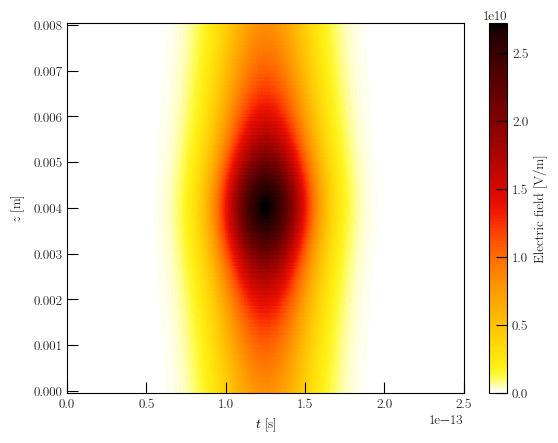

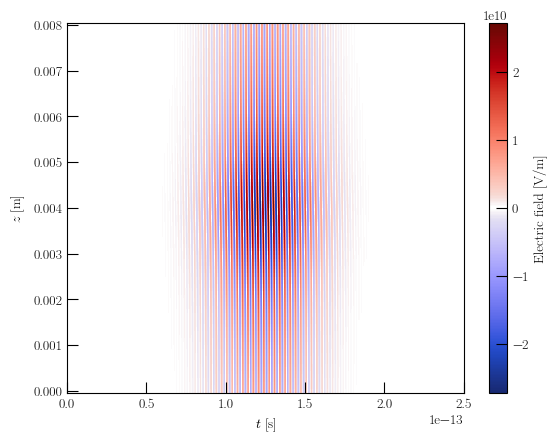

In [5]:
# Let's plot the envelope of the on-axis electric field
plt.figure()
np.abs(ds_line['E']).plot(cmap='cet_fire_r')
plt.show()

# Or its real part
plt.figure()
np.real(ds_line['E']).plot(cmap='BR')
plt.show()

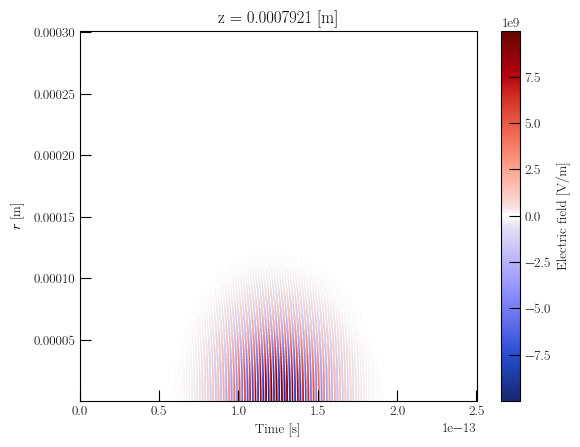

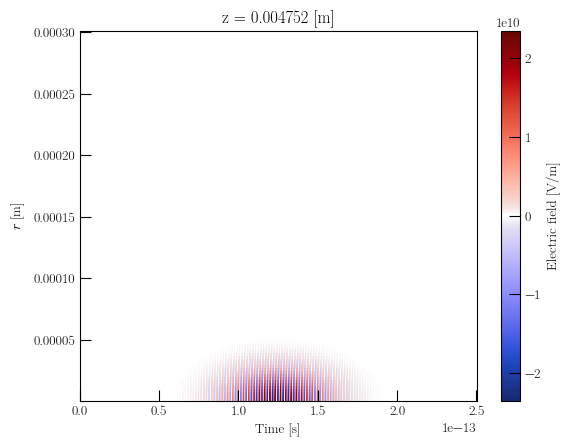

In [6]:
# How about the electric field profile at the second distance?
plt.figure()
np.real(da_e[1, :, :]).plot(cmap='BR')
plt.show()

# What if we want the full electric field closest to z = 0.005?
plt.figure()
np.real(da_e.sel(z=0.005, method="nearest")).plot(cmap='BR')
plt.show()

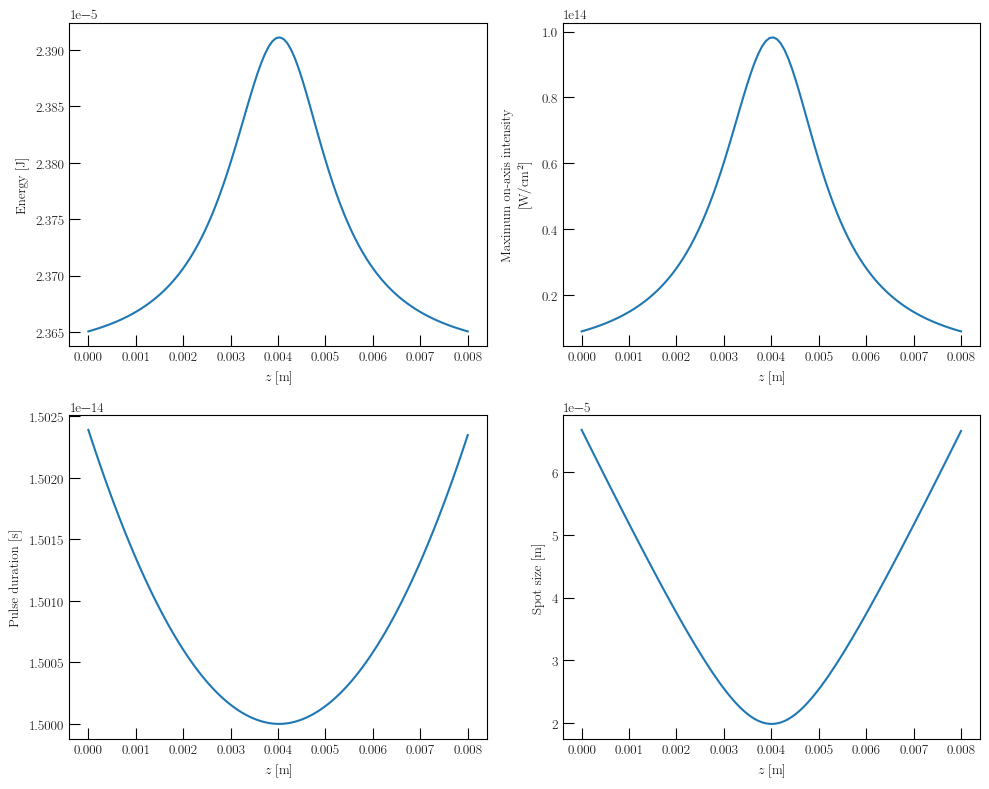

In [7]:
# Let's make one plot with various lineout quantities
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,8))

# Energy
ds_line['U'].plot(ax=ax[0, 0])

# On-axis intensity
ds_line['I0'].plot(ax=ax[0, 1])

# Energy
ds_line['tau'].plot(ax=ax[1, 0])

# On-axis intensity
ds_line['w0'].plot(ax=ax[1, 1])

plt.tight_layout()
plt.show()

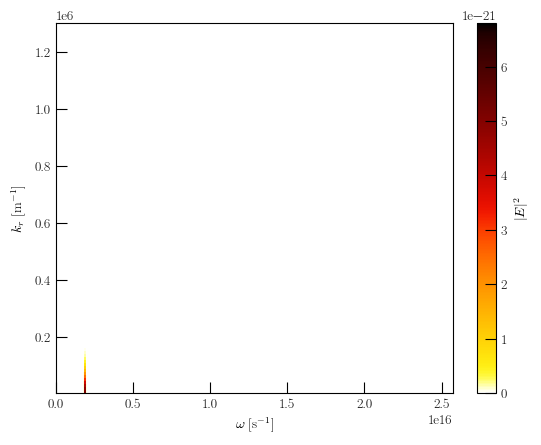

In [8]:
# Finally, let's plot the transformed field as a function of k and omega at the second z distance

# First, take an ifft and take only positive frequencies to get a function of r and omega
e_rw = np.fft.ifft(da_e[1, :, :], norm="ortho")[:, :i_pos_omega]

# Second, perform the Hankel transform to get a function of k and omega
e_kw = np.matmul(T_R2K, e_rw)

# Construct a DataArray with the transformed data
da_e_kw = xr.DataArray(
    e_kw,
    coords=[
        ("k", kperp, {"long_name": "$k_r$", "units": "m$^{-1}$"}),
        ("omega", omega[:i_pos_omega], {"long_name": "$\omega$", "units": "s$^{-1}$"}),
    ],
    attrs={"long_name": "Transformed electric field"},
)

plt.figure()
# See online documentation of the xarray.plot.pcolormesh function for info on the keyword arguments
np.square(np.abs(da_e_kw)).plot(cmap='cet_fire_r', cbar_kwargs={"label": "$|E|^2$"})
plt.show()